In [1]:
#Import desired tools needed for data collections and analysis
import numpy as np
import pandas as pd
import json
import requests
import gmaps
import matplotlib.pyplot as plt
from scipy.stats import linregress
from us import states
from config import api_key, gmaps_api_key
from census import Census
from config import census_key
c = Census(census_key, year=2018)

In [2]:
#Read josn file listing all cities in the OpenWeather API
city_list = pd.read_json("ProjectOne/city.list.json", orient="list")

#Select US cities from list
US_city_list = city_list.loc[city_list["country"] == "US", :]
US_city_list

,id,name,state,country,coord
141897,4046255,Bay Minette,AL,US,"{'lon': -87.773048, 'lat': 30.882959}"
141898,4046274,Edna,TX,US,"{'lon': -96.646088, 'lat': 28.97859}"
141899,4046319,Bayou La Batre,AL,US,"{'lon': -88.24852, 'lat': 30.403521}"
141900,4046332,Henderson,TX,US,"{'lon': -94.799377, 'lat': 32.153221}"
141901,4046430,Natalia,TX,US,"{'lon': -98.862534, 'lat': 29.18968}"
...,...,...,...,...,...
208905,8122840,Western Community Park,KS,US,"{'lon': -97.680717, 'lat': 38.367432}"
208906,8122866,Happy Homes Park,KS,US,"{'lon': -99.976273, 'lat': 37.7458}"
208907,8123060,Western Mobile Home Park South,KS,US,"{'lon': -100.939072, 'lat': 37.03735}"
209568,8260172,West Greenwich,RI,US,"{'lon': -71.660042, 'lat': 41.637001}"


In [3]:
#Separate coordinates into 2 data series for longitude and latitude
US_Cities = pd.concat([US_city_list.drop(['coord'], axis=1), US_city_list['coord'].apply(pd.Series)], axis=1)
US_Cities

,id,name,state,country,lon,lat
141897,4046255,Bay Minette,AL,US,-87.773048,30.882959
141898,4046274,Edna,TX,US,-96.646088,28.978590
141899,4046319,Bayou La Batre,AL,US,-88.248520,30.403521
141900,4046332,Henderson,TX,US,-94.799377,32.153221
141901,4046430,Natalia,TX,US,-98.862534,29.189680
...,...,...,...,...,...,...
208905,8122840,Western Community Park,KS,US,-97.680717,38.367432
208906,8122866,Happy Homes Park,KS,US,-99.976273,37.745800
208907,8123060,Western Mobile Home Park South,KS,US,-100.939072,37.037350
209568,8260172,West Greenwich,RI,US,-71.660042,41.637001


In [51]:
#Find coordinates for KC MO
KS_City_MO = US_Cities.loc[(US_Cities["state"] == "MO") & (US_Cities["name"] == "Kansas City"),
                           :].reset_index(drop=True)
KS_City_MO

,id,name,state,country,lon,lat
0,4393217,Kansas City,MO,US,-94.578568,39.099731


In [40]:
KCMO_lat = KS_City_MO.iloc[0,5]
KCMO_lon = KS_City_MO.iloc[0,4]
KCMO_lat

39.099731

In [52]:
#Create list of cities near KC MO
KC_area = US_Cities.loc[((US_Cities["lat"] > 38.59)&(US_Cities["lat"] < 39.59)&(US_Cities["lon"] > -95.08)&(US_Cities["lon"] < -94.08))].reset_index(drop=True)
KC_area

,id,name,state,country,lon,lat
0,4049176,Chandler,MO,US,-94.382729,39.300282
1,4267944,Basehor,KS,US,-94.938583,39.141670
2,4268521,Bonner Springs,KS,US,-94.883583,39.059731
3,4269615,Clare,KS,US,-94.871353,38.826950
4,4270269,De Soto,KS,US,-94.968582,38.979172
...,...,...,...,...,...,...
68,4406747,Sadler,MO,US,-94.941910,39.438610
69,4409199,Smithville,MO,US,-94.581070,39.386940
70,4410585,Sugar Creek,MO,US,-94.444672,39.109730
71,4413815,Weatherby Lake,MO,US,-94.696068,39.237782


In [53]:
#Create data frame with columns for desired climate information
KC_area_data = pd.DataFrame({"City": KC_area["name"],
                             "Lat": KC_area["lat"],
                             "Lng": KC_area["lon"],
                             "Timezone_Offset": "",
                             "Current Date": "",
                             "Current Temp": "",
                             "Day1 High": "",
                             "Day2 High": "",
                             "Day3 High": "",
                             "Day4 High": "",
                             "Day5 High": ""
                             })
KC_area_data

,City,Lat,Lng,Timezone_Offset,Current Date,Current Temp,Day1 High,Day2 High,Day3 High,Day4 High,Day5 High
0,Chandler,39.300282,-94.382729,,,,,,,,
1,Basehor,39.141670,-94.938583,,,,,,,,
2,Bonner Springs,39.059731,-94.883583,,,,,,,,
3,Clare,38.826950,-94.871353,,,,,,,,
4,De Soto,38.979172,-94.968582,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
68,Sadler,39.438610,-94.941910,,,,,,,,
69,Smithville,39.386940,-94.581070,,,,,,,,
70,Sugar Creek,39.109730,-94.444672,,,,,,,,
71,Weatherby Lake,39.237782,-94.696068,,,,,,,,


In [54]:
#Query the OpenWeather API and place desired data into data frame

part = "minutely,hourly"

for index, row in KC_area_data.iterrows():
    lat = row["Lat"]
    lon = row["Lng"]

    URL = f"https://api.openweathermap.org/data/2.5/onecall?lat={lat}&lon={lon}&exclude={part}&units=imperial&appid={api_key}"
    response = requests.get(URL).json()
    
    KC_area_data.loc[index,"Timezone_Offset"] = response["timezone_offset"]
    KC_area_data.loc[index,"Current Date"] = response["current"]["dt"]
    KC_area_data.loc[index,"Current Temp"] = response["current"]["temp"]
    KC_area_data.loc[index,"Day1 High"] = response["daily"][0]["temp"]["max"]
    KC_area_data.loc[index,"Day2 High"] = response["daily"][1]["temp"]["max"]
    KC_area_data.loc[index,"Day3 High"] = response["daily"][2]["temp"]["max"]
    KC_area_data.loc[index,"Day4 High"] = response["daily"][3]["temp"]["max"]
    KC_area_data.loc[index,"Day5 High"] = response["daily"][4]["temp"]["max"]
     
KC_area_data

,City,Lat,Lng,Timezone_Offset,Current Date,Current Temp,Day1 High,Day2 High,Day3 High,Day4 High,Day5 High
0,Chandler,39.300282,-94.382729,-18000,1591737640,87.87,87.87,71.06,81.36,82.89,80.26
1,Basehor,39.141670,-94.938583,-18000,1591737641,88.83,88.83,72.45,81.77,83.32,81.79
2,Bonner Springs,39.059731,-94.883583,-18000,1591737641,89.17,89.17,73.11,82.45,84,82.26
3,Clare,38.826950,-94.871353,-18000,1591737641,88.65,88.65,72.23,81.21,82.54,80.89
4,De Soto,38.979172,-94.968582,-18000,1591737642,89.11,89.11,73.09,82.42,84.02,81.79
...,...,...,...,...,...,...,...,...,...,...,...
68,Sadler,39.438610,-94.941910,-18000,1591737673,89.02,89.02,72.23,81.59,83.46,81.54
69,Smithville,39.386940,-94.581070,-18000,1591737674,87.19,87.19,71.73,81.34,83.14,80.65
70,Sugar Creek,39.109730,-94.444672,-18000,1591737674,88.2,88.2,71.78,81.84,83.48,80.87
71,Weatherby Lake,39.237782,-94.696068,-18000,1591737674,87.73,87.73,72.07,81.46,83.17,81.9


In [55]:
# Configure gmaps
gmaps.configure(api_key=gmaps_api_key)

figure_layout = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)

In [56]:
#define coordinates from KC_area_data
coordinates = []
temperatures = []

for index, row in KC_area_data.iterrows():
    lat = row["Lat"]
    lon = row["Lng"]
    coordinates.append((lat, lon))
    
    temp = row["Day2 High"]
    temperatures.append(str(temp))

coordinates

[(39.300282, -94.382729),
 (39.14167, -94.938583),
 (39.059731, -94.883583),
 (38.82695, -94.871353),
 (38.979172, -94.968582),
 (38.764729, -95.008018),
 (39.061119, -94.819679),
 (39.022228, -94.631897),
 (38.810840999999996, -94.927193),
 (38.866669, -94.866913),
 (39.11417, -94.627457),
 (39.248611, -94.900238),
 (39.311111, -94.922462),
 (39.23333, -95.033577),
 (38.966671, -94.616898),
 (38.953621, -94.733566),
 (38.619461, -94.680794),
 (39.023621, -94.693573),
 (39.027779, -94.655792),
 (39.01778, -94.616898),
 (38.850288, -94.723846),
 (38.881401, -94.81913),
 (38.982231, -94.670792),
 (38.991669, -94.633568),
 (39.03751, -94.632179),
 (39.041672, -94.720238),
 (38.743061, -94.825523),
 (39.040562, -94.616898),
 (39.116669, -94.716904),
 (39.223339, -94.113281),
 (38.811951, -94.531898),
 (39.016949, -94.281609),
 (39.132511, -94.198563),
 (39.452782, -94.741631),
 (38.650009, -94.36689),
 (39.316669, -94.40023),
 (39.202499, -94.492447),
 (39.095558, -94.355232),
 (39.339169,

In [57]:
fig = gmaps.figure(center=(KCMO_lat,KCMO_lon), zoom_level=9.1)

heat_layer = gmaps.heatmap_layer(coordinates, weights=KC_area_data["Day2 High"], 
                                 dissipating=False, max_intensity=KC_area_data["Day2 High"].max(),
                                 point_radius = .1)

marker = gmaps.marker_layer(coordinates, label=temperatures)

# Add the layer to the map
fig.add_layer(heat_layer)

fig.add_layer(marker)


fig

Figure(layout=FigureLayout(height='420px'))

In [58]:
KC_area_data.columns

Index(['City', 'Lat', 'Lng', 'Timezone_Offset', 'Current Date', 'Current Temp',
       'Day1 High', 'Day2 High', 'Day3 High', 'Day4 High', 'Day5 High'],
      dtype='object')

In [59]:
KC_area_data.loc[(KC_area_data["Lat"]==KCMO_lat)&(KC_area_data["Lng"]==KCMO_lon)]

,City,Lat,Lng,Timezone_Offset,Current Date,Current Temp,Day1 High,Day2 High,Day3 High,Day4 High,Day5 High
46,Kansas City,39.099731,-94.578568,-18000,1591737663,88.34,88.34,72.37,82.11,83.7,81.48


In [60]:
#Create new data frame to compare distance from KC MO to temperature
KC_Metro_comparison = KC_area_data[["City", "Lat", "Lng", "Day1 High", 
                               "Day2 High", "Day3 High", "Day4 High",
                               "Day5 High"]]
#KC_Metro_comparison = KC_Metro_comparison(columns=["Chng Lat", "Chng Lng", 
#                                                            "Day1 Chng", "Day2 Chng", 
#                                                            "Day3 Chng", "Day4 Chng", 
#                                                            "Day5 Chng"])

for index, row in KC_Metro_comparison.iterrows():

    KC_Metro_comparison.loc[index, "Chng Lat"] = abs(KCMO_lat - row["Lat"])
    KC_Metro_comparison.loc[index, "Chng Lng"] = abs(KCMO_lon - row["Lng"])
    KC_Metro_comparison.loc[index, "Day1 Chng"] = row["Day1 High"] - KC_area_data.iloc[46, 6]
    KC_Metro_comparison.loc[index, "Day2 Chng"] = row["Day2 High"] - KC_area_data.iloc[46, 7]
    KC_Metro_comparison.loc[index, "Day3 Chng"] = row["Day3 High"] - KC_area_data.iloc[46, 8]
    KC_Metro_comparison.loc[index, "Day4 Chng"] = row["Day4 High"] - KC_area_data.iloc[46, 9]
    KC_Metro_comparison.loc[index, "Day5 Chng"] = row["Day5 High"] - KC_area_data.iloc[46, 10]


KC_Metro_comparison

C:\Users\Travis Young\anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Travis Young\anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,City,Lat,Lng,Day1 High,Day2 High,Day3 High,Day4 High,Day5 High,Chng Lat,Chng Lng,Day1 Chng,Day2 Chng,Day3 Chng,Day4 Chng,Day5 Chng
0,Chandler,39.300282,-94.382729,87.87,71.06,81.36,82.89,80.26,0.200551,0.195839,-0.47,-1.31,-0.75,-0.81,-1.22
1,Basehor,39.141670,-94.938583,88.83,72.45,81.77,83.32,81.79,0.041939,0.360015,0.49,0.08,-0.34,-0.38,0.31
2,Bonner Springs,39.059731,-94.883583,89.17,73.11,82.45,84,82.26,0.040000,0.305015,0.83,0.74,0.34,0.30,0.78
3,Clare,38.826950,-94.871353,88.65,72.23,81.21,82.54,80.89,0.272781,0.292785,0.31,-0.14,-0.90,-1.16,-0.59
4,De Soto,38.979172,-94.968582,89.11,73.09,82.42,84.02,81.79,0.120559,0.390014,0.77,0.72,0.31,0.32,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Sadler,39.438610,-94.941910,89.02,72.23,81.59,83.46,81.54,0.338879,0.363342,0.68,-0.14,-0.52,-0.24,0.06
69,Smithville,39.386940,-94.581070,87.19,71.73,81.34,83.14,80.65,0.287209,0.002502,-1.15,-0.64,-0.77,-0.56,-0.83
70,Sugar Creek,39.109730,-94.444672,88.2,71.78,81.84,83.48,80.87,0.009999,0.133896,-0.14,-0.59,-0.27,-0.22,-0.61
71,Weatherby Lake,39.237782,-94.696068,87.73,72.07,81.46,83.17,81.9,0.138051,0.117500,-0.61,-0.30,-0.65,-0.53,0.42


In [61]:
#Calculating distance from changes in latitude and longitude 
#formulas from https://www.sisense.com/blog/latitude-longitude-distance-calculation-explained/

#a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)

#c = 2 * atan2( √a, √(1−a) )

#d = R * c

#Where φ represent the latitudes, and λ represent the longitudes.
KClat = KC_area_data.iloc[43, 1]

for index, row in KC_Metro_comparison.iterrows():
    KC_Metro_comparison.loc[index, "a"] = np.sin(np.deg2rad(row["Chng Lat"])/2)**2 + ((np.cos(np.deg2rad(row["Lat"]))) * (np.cos(np.deg2rad(KClat))) * (np.sin(np.deg2rad(row["Chng Lng"])/2)**2))    
for index, row in KC_Metro_comparison.iterrows():    
    KC_Metro_comparison.loc[index, "Distance (miles)"] = round((2 * (np.arctan2((np.sqrt(row["a"])), (np.sqrt(1-row["a"]))))) *3958.8, 2)
    
#for index, row in KC_Metro_comparison.iterrows():  
#    KC_Metro_comparison.loc[index, "Distance"] = 3,958.8 * row["c"]
#distance = 3,958.8 * c

KC_Metro_comparison

,City,Lat,Lng,Day1 High,Day2 High,Day3 High,Day4 High,Day5 High,Chng Lat,Chng Lng,Day1 Chng,Day2 Chng,Day3 Chng,Day4 Chng,Day5 Chng,a,Distance (miles)
0,Chandler,39.300282,-94.382729,87.87,71.06,81.36,82.89,80.26,0.200551,0.195839,-0.47,-1.31,-0.75,-0.81,-1.22,4.828039e-06,17.40
1,Basehor,39.141670,-94.938583,88.83,72.45,81.77,83.32,81.79,0.041939,0.360015,0.49,0.08,-0.34,-0.38,0.31,6.112314e-06,19.57
2,Bonner Springs,39.059731,-94.883583,89.17,73.11,82.45,84,82.26,0.040000,0.305015,0.83,0.74,0.34,0.30,0.78,4.418091e-06,16.64
3,Clare,38.826950,-94.871353,88.65,72.23,81.21,82.54,80.89,0.272781,0.292785,0.31,-0.14,-0.90,-1.16,-0.59,9.638238e-06,24.58
4,De Soto,38.979172,-94.968582,89.11,73.09,82.42,84.02,81.79,0.120559,0.390014,0.77,0.72,0.31,0.32,0.31,8.139224e-06,22.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Sadler,39.438610,-94.941910,89.02,72.23,81.59,83.46,81.54,0.338879,0.363342,0.68,-0.14,-0.52,-0.24,0.06,1.480907e-05,30.47
69,Smithville,39.386940,-94.581070,87.19,71.73,81.34,83.14,80.65,0.287209,0.002502,-1.15,-0.64,-0.77,-0.56,-0.83,6.282172e-06,19.84
70,Sugar Creek,39.109730,-94.444672,88.2,71.78,81.84,83.48,80.87,0.009999,0.133896,-0.14,-0.59,-0.27,-0.22,-0.61,8.349363e-07,7.23
71,Weatherby Lake,39.237782,-94.696068,87.73,72.07,81.46,83.17,81.9,0.138051,0.117500,-0.61,-0.30,-0.65,-0.53,0.42,2.087307e-06,11.44


In [62]:
KC_Metro_comparison_sorted = KC_Metro_comparison.sort_values("Distance (miles)")
KC_Metro_comparison_sorted

,City,Lat,Lng,Day1 High,Day2 High,Day3 High,Day4 High,Day5 High,Chng Lat,Chng Lng,Day1 Chng,Day2 Chng,Day3 Chng,Day4 Chng,Day5 Chng,a,Distance (miles)
46,Kansas City,39.099731,-94.578568,88.34,72.37,82.11,83.7,81.48,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.00
55,North Kansas City,39.130001,-94.562180,88.36,72.79,82.62,84.15,81.88,0.030270,0.016388,0.02,0.42,0.51,0.45,0.40,8.216804e-08,2.27
10,Kansas City,39.114170,-94.627457,88.45,72.73,82.33,83.91,81.97,0.014439,0.048889,0.11,0.36,0.22,0.21,0.49,1.261667e-07,2.81
27,Westwood,39.040562,-94.616898,88.88,72.41,81.99,83.61,81.5,0.059169,0.038330,0.54,0.04,-0.12,-0.09,0.02,3.344787e-07,4.58
24,Roeland Park,39.037510,-94.632179,88.88,72.41,81.99,83.59,81.52,0.062221,0.053611,0.54,0.04,-0.12,-0.11,0.04,4.275955e-07,5.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,Plattsburg,39.565552,-94.448013,86.95,70.7,80.13,82.22,79.56,0.465821,0.130555,-1.39,-1.67,-1.98,-1.48,-1.92,1.730602e-05,32.94
34,Cass County,38.650009,-94.366890,88.75,71.8,80.24,82.08,80.74,0.449722,0.211678,0.41,-0.57,-1.87,-1.62,-0.74,1.748327e-05,33.11
43,Harrisonville,38.653339,-94.348839,88.79,71.58,80.02,81.95,80.56,0.446392,0.229729,0.45,-0.79,-2.09,-1.75,-0.92,1.762598e-05,33.24
16,Louisburg,38.619461,-94.680794,87.75,71.67,80.06,81.79,80.11,0.480270,0.102226,-0.59,-0.70,-2.05,-1.91,-1.37,1.805118e-05,33.64


Text(0, 0.5, 'Change in Temperature')

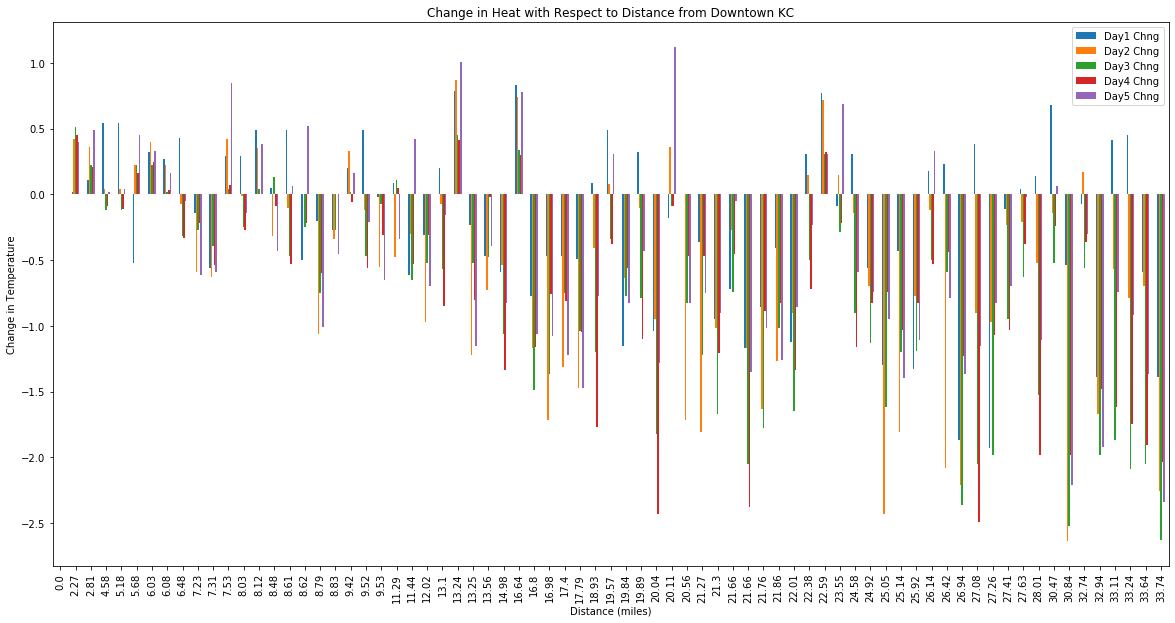

In [63]:
#Plot distance from downtown vs change in temperature
KC_Metro_comparison_sorted.plot.bar(x="Distance (miles)", y=["Day1 Chng","Day2 Chng", "Day3 Chng", "Day4 Chng", "Day5 Chng"], figsize=(20,10))
#KC_Metro_comparison_sorted.plot.bar(x="Distance (miles)", y="Day2 Chng", figsize=(20,3))
plt.title("Change in Heat with Respect to Distance from Downtown KC")
plt.xlabel("Distance (miles)")
plt.ylabel("Change in Temperature")

In [64]:
#Linear Regression Analysis
#make distance v change in temp data set
D1_Temp_V_Dist = KC_Metro_comparison[["Distance (miles)", "Day1 Chng"]]
D2_Temp_V_Dist = KC_Metro_comparison[["Distance (miles)", "Day2 Chng"]]
D3_Temp_V_Dist = KC_Metro_comparison[["Distance (miles)", "Day3 Chng"]]
D4_Temp_V_Dist = KC_Metro_comparison[["Distance (miles)", "Day4 Chng"]]
D5_Temp_V_Dist = KC_Metro_comparison[["Distance (miles)", "Day5 Chng"]]

#Rename new dataframe columns to prepare for combining dataframes
D1_Temp_V_Dist = D1_Temp_V_Dist.rename(columns={"Day1 Chng": "Temp Change"})
D2_Temp_V_Dist = D1_Temp_V_Dist.rename(columns={"Day2 Chng": "Temp Change"})
D3_Temp_V_Dist = D1_Temp_V_Dist.rename(columns={"Day3 Chng": "Temp Change"})
D4_Temp_V_Dist = D1_Temp_V_Dist.rename(columns={"Day4 Chng": "Temp Change"})
D5_Temp_V_Dist = D1_Temp_V_Dist.rename(columns={"Day5 Chng": "Temp Change"})

#Concatinate dataframes
#df.append(df2)
#pd.concat([t1, t2, t3, t4, t5])
Temp_V_Dist = D1_Temp_V_Dist.append(D2_Temp_V_Dist)
Temp_V_Dist = Temp_V_Dist.append(D3_Temp_V_Dist)
Temp_V_Dist = Temp_V_Dist.append(D4_Temp_V_Dist)
Temp_V_Dist = Temp_V_Dist.append(D5_Temp_V_Dist)
Temp_V_Dist

,Distance (miles),Temp Change
0,17.40,-0.47
1,19.57,0.49
2,16.64,0.83
3,24.58,0.31
4,22.59,0.77
...,...,...
68,30.47,0.68
69,19.84,-1.15
70,7.23,-0.14
71,11.44,-0.61


The r-squared is: 0.1


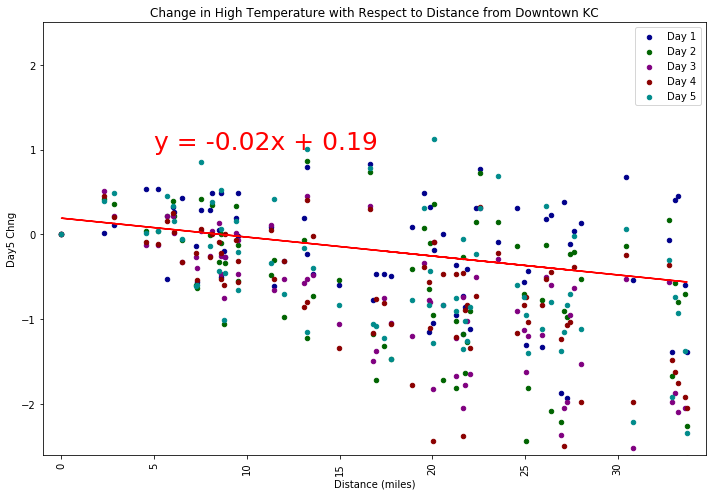

In [66]:
ax = KC_Metro_comparison.plot.scatter(x="Distance (miles)", y="Day1 Chng", color="DarkBlue", label="Day 1", figsize=(10,7))
ax1 = KC_Metro_comparison.plot.scatter(x="Distance (miles)", y="Day2 Chng", color="DarkGreen", label="Day 2", ax=ax)
ax2 = KC_Metro_comparison.plot.scatter(x="Distance (miles)", y="Day3 Chng", color="Purple", label="Day 3", ax=ax)
ax3 = KC_Metro_comparison.plot.scatter(x="Distance (miles)", y="Day4 Chng", color="DarkRed", label="Day 4", ax=ax)
ax4 = KC_Metro_comparison.plot.scatter(x="Distance (miles)", y="Day5 Chng", color="DarkCyan", label="Day 5", ax=ax)

x_values = Temp_V_Dist["Distance (miles)"]
y_values = Temp_V_Dist["Temp Change"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5, 1),fontsize=25,color="red")
print(f"The r-squared is: {round(rvalue**2, 2)}")
plt.title("Change in High Temperature with Respect to Distance from Downtown KC")
plt.xlabel("Distance (miles)")
plt.xticks(rotation="vertical")
plt.xlim(-1, max(KC_Metro_comparison["Distance (miles)"])+1)
plt.ylim(-2.6, 2.5)
plt.tight_layout()


The r-squared is: 0.14
The r-squared is: 0.45
The r-squared is: 0.47
The r-squared is: 0.46
The r-squared is: 0.35


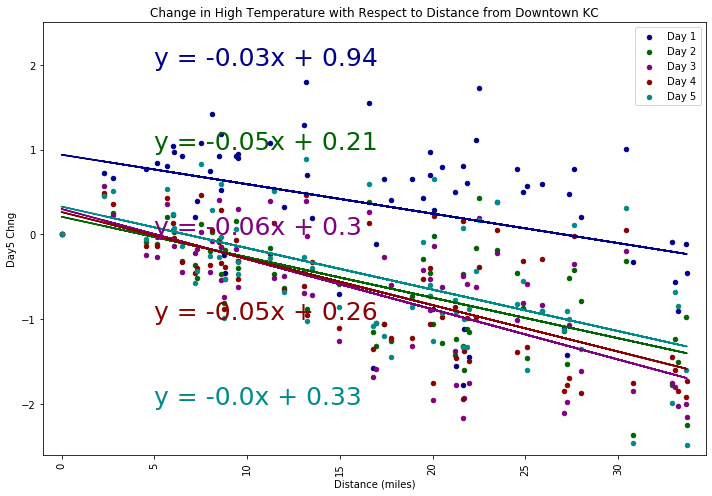

In [175]:
ax = KC_Metro_comparison.plot.scatter(x="Distance (miles)", y="Day1 Chng", color="DarkBlue", label="Day 1", figsize=(10,7))
ax1 = KC_Metro_comparison.plot.scatter(x="Distance (miles)", y="Day2 Chng", color="DarkGreen", label="Day 2", ax=ax)
ax2 = KC_Metro_comparison.plot.scatter(x="Distance (miles)", y="Day3 Chng", color="Purple", label="Day 3", ax=ax)
ax3 = KC_Metro_comparison.plot.scatter(x="Distance (miles)", y="Day4 Chng", color="DarkRed", label="Day 4", ax=ax)
ax4 = KC_Metro_comparison.plot.scatter(x="Distance (miles)", y="Day5 Chng", color="DarkCyan", label="Day 5", ax=ax)

x_values = KC_Metro_comparison["Distance (miles)"]
y_values = KC_Metro_comparison["Day1 Chng"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-",color="DarkBlue")
plt.annotate(line_eq,(5, 2),fontsize=25,color="DarkBlue")
print(f"The r-squared is: {round(rvalue**2, 2)}")

x_values = KC_Metro_comparison["Distance (miles)"]
y2_values = KC_Metro_comparison["Day2 Chng"]
(slope2, intercept2, rvalue2, pvalue2, stderr2) = linregress(x_values, y2_values)
regress_values2 = x_values * slope2 + intercept2
line_eq2 = "y = " + str(round(slope2,2)) + "x + " + str(round(intercept2,2))
plt.plot(x_values,regress_values2,"r-",color="DarkGreen")
plt.annotate(line_eq2,(5, 1),fontsize=25,color="DarkGreen")
print(f"The r-squared is: {round(rvalue2**2, 2)}")

x_values = KC_Metro_comparison["Distance (miles)"]
y3_values = KC_Metro_comparison["Day3 Chng"]
(slope3, intercept3, rvalue3, pvalue3, stderr3) = linregress(x_values, y3_values)
regress_values3 = x_values * slope3 + intercept3
line_eq3 = "y = " + str(round(slope3,2)) + "x + " + str(round(intercept3,2))
plt.plot(x_values,regress_values3,"r-",color="Purple")
plt.annotate(line_eq3,(5, 0),fontsize=25,color="Purple")
print(f"The r-squared is: {round(rvalue3**2, 2)}")

x_values = KC_Metro_comparison["Distance (miles)"]
y4_values = KC_Metro_comparison["Day4 Chng"]
(slope4, intercept4, rvalue4, pvalue4, stderr4) = linregress(x_values, y4_values)
regress_values4 = x_values * slope4 + intercept4
line_eq4 = "y = " + str(round(slope4,2)) + "x + " + str(round(intercept4,2))
plt.plot(x_values,regress_values4,"r-",color="DarkRed")
plt.annotate(line_eq4,(5, -1),fontsize=25,color="DarkRed")
print(f"The r-squared is: {round(rvalue4**2, 2)}")

x_values = KC_Metro_comparison["Distance (miles)"]
y5_values = KC_Metro_comparison["Day5 Chng"]
(slope5, intercept5, rvalue5, pvalue5, stderr5) = linregress(x_values, y5_values)
regress_values5 = x_values * slope5 + intercept5
line_eq5 = "y = " + str(round(slope5,-2)) + "x + " + str(round(intercept5,2))
plt.plot(x_values,regress_values5,"r-",color="DarkCyan")
plt.annotate(line_eq5,(5, -2),fontsize=25,color="DarkCyan")
print(f"The r-squared is: {round(rvalue5**2, 2)}")

plt.title("Change in High Temperature with Respect to Distance from Downtown KC")
plt.xlabel("Distance (miles)")
plt.xticks(rotation="vertical")
plt.xlim(-1, max(KC_Metro_comparison["Distance (miles)"])+1)
plt.ylim(-2.6, 2.5)
plt.tight_layout()
plt.savefig("temp_vs_dist.png")

# Collect Population Data from Census API

In [67]:
census_data = c.acs5.get(("NAME", "B01003_001E"), 
                         {'for': 'zip code tabulation area:*'})
#, 'in': 'state:{}'.format(states.KS.fips)
                     #       {'for': 'zip code tabulation area:*'}

#for=zip+code+tabulation+area:*&in=state:02
#c.acs5.get(('NAME', 'B25034_010E'),
#          {'for': 'state:{}'.format(states.MD.fips)})
# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

census_pd = census_pd[["Zipcode", "Population"]]
                       
census_pd

,Zipcode,Population
0,43964,8642.0
1,28216,51116.0
2,28277,71605.0
3,28278,27286.0
4,28303,29414.0
...,...,...
33115,98279,628.0
33116,98280,417.0
33117,98311,27856.0
33118,98326,657.0


In [113]:
#Read josn file listing all zip codes in KS
#json file was downloaded from https://public.opendatasoft.com/
Zips = pd.read_json("ProjectOne/Zip_Lat_Lon.json", orient="list")
print(Zips['geometry'])

0        {'type': 'Point', 'coordinates': [-94.39398, 3...
1        {'type': 'Point', 'coordinates': [-92.16056, 3...
2        {'type': 'Point', 'coordinates': [-94.74357, 4...
3        {'type': 'Point', 'coordinates': [-85.89754, 4...
4        {'type': 'Point', 'coordinates': [-91.98027, 4...
                               ...                        
43186    {'type': 'Point', 'coordinates': [-79.93414, 4...
43187    {'type': 'Point', 'coordinates': [-91.54559, 4...
43188    {'type': 'Point', 'coordinates': [-78.07012, 4...
43189    {'type': 'Point', 'coordinates': [-93.47188, 4...
43190    {'type': 'Point', 'coordinates': [-76.594942, ...
Name: geometry, Length: 43191, dtype: object


In [114]:
Zips.columns

Index(['datasetid', 'recordid', 'fields', 'geometry', 'record_timestamp'], dtype='object')

In [115]:
Zips['fields']

0        {'city': 'Cove', 'zip': '71937', 'dst': 1, 'ge...
1        {'city': 'Edgemont', 'zip': '72044', 'dst': 1,...
2        {'city': 'Sherburn', 'zip': '56171', 'dst': 1,...
3        {'city': 'Lamont', 'zip': '49430', 'dst': 1, '...
4        {'city': 'Richland', 'zip': '52585', 'dst': 1,...
                               ...                        
43186    {'city': 'Pittsburgh', 'zip': '15207', 'dst': ...
43187    {'city': 'Olds', 'zip': '52647', 'dst': 1, 'ge...
43188    {'city': 'Spruce Creek', 'zip': '16683', 'dst'...
43189    {'city': 'Minneapolis', 'zip': '55459', 'dst':...
43190    {'city': 'Pasadena', 'zip': '21123', 'dst': 1,...
Name: fields, Length: 43191, dtype: object

In [117]:
Zip = pd.concat([Zips.drop(['fields'], axis=1), Zips['fields'].apply(pd.Series)], axis=1)
Zip_Codes = Zip[["city", "state", "zip", "latitude", "longitude"]]
Zip_Codes = Zip_Codes.rename(columns={"zip": "Zipcode"})
Zip_Codes = Zip_Codes.loc[(Zip_Codes["state"] == "MO")|(Zip_Codes["state"] == "KS")]
Zip_Codes["state"].unique()

array(['MO', 'KS'], dtype=object)

In [119]:
Population_df = pd.merge(census_pd, Zip_Codes, on="Zipcode")
Population_df

,Zipcode,Population,city,state,latitude,longitude
0,63461,5709.0,Palmyra,MO,39.793879,-91.54631
1,63468,2414.0,Shelbina,MO,39.677131,-92.01662
2,63471,644.0,Taylor,MO,39.925941,-91.49636
3,63532,1397.0,Bevier,MO,39.754960,-92.57057
4,63541,346.0,Glenwood,MO,40.513638,-92.60818
...,...,...,...,...,...,...
1713,66010,762.0,Blue Mound,KS,38.102749,-95.01540
1714,67207,28313.0,Wichita,KS,37.669803,-97.23289
1715,67344,931.0,Elk City,KS,37.279439,-95.93171
1716,67859,797.0,Kismet,KS,37.235210,-100.75208


In [120]:
Population_df.dtypes

Zipcode        object
Population    float64
city           object
state          object
latitude      float64
longitude     float64
dtype: object

In [121]:
Pop_coord = []
Pop_markers = []

for index, row in Population_df.iterrows():
    lat = row["latitude"]
    lon = row["longitude"]
    Pop_coord.append((lat, lon))


#for index, row in KC_Metro.iterrows():
    population = row["Population"]
    Pop_markers.append(str(population))
Pop_coord

[(39.793879, -91.54631),
 (39.677131, -92.01662),
 (39.925941, -91.49636),
 (39.75496, -92.57057),
 (40.513638, -92.60818),
 (37.54834, -90.30599),
 (37.833644, -89.98417),
 (37.157131, -89.44651),
 (37.437077, -89.85836),
 (37.265867, -89.82401),
 (36.915335, -89.31308),
 (36.180226, -89.84072),
 (37.248929, -90.42887),
 (38.638318, -90.427118),
 (38.194104, -90.472495),
 (38.252726, -90.514875),
 (38.341918, -90.408223),
 (38.527729, -91.017274),
 (38.274398, -91.085533),
 (38.6531, -90.243462),
 (39.650045, -91.270502),
 (37.327153, -91.024337),
 (37.197279, -89.739429),
 (37.24237, -89.69768),
 (37.734776, -89.811616),
 (36.712451, -90.407013),
 (36.712451, -90.407013),
 (38.610701, -90.21362),
 (38.120303, -90.55426),
 (37.527341, -89.92735),
 (36.058612, -89.87038),
 (36.956662, -90.13128),
 (38.226997, -90.38215),
 (38.576253, -90.53117),
 (38.129238, -90.74342),
 (38.79505, -90.28578),
 (38.832863, -90.29051),
 (38.725331, -90.44451),
 (38.259946, -90.5666),
 (38.558836, -91.24

In [76]:
KS_city_data

NameError: name 'KS_city_data' is not defined

In [122]:
reduced_coords = []
reduced_temps = []

for index, row in KC_area_data.iterrows():
    if index % 5 == 0:
        lat = row["Lat"]
        lon = row["Lng"]
        reduced_coords.append((lat, lon))
    
        temp = row["Day2 High"]
        reduced_temps.append(str(temp))
    
reduced_coords

[(39.300282, -94.382729),
 (38.764729, -95.008018),
 (39.11417, -94.627457),
 (38.953621, -94.733566),
 (38.850288, -94.723846),
 (39.041672, -94.720238),
 (38.811951, -94.531898),
 (39.316669, -94.40023),
 (39.015011, -94.198563),
 (39.01667, -94.350227),
 (39.54834, -94.329948),
 (39.130001, -94.56218),
 (39.416672, -94.80024),
 (39.008621, -94.463562),
 (39.10973, -94.444672)]

In [125]:
# Map temperature in all cities in list
fig = gmaps.figure(center=(KCMO_lat,KCMO_lon), zoom_level=7)
#fig = gmaps.figure(map_type='HYBRID')
heat_layer = gmaps.heatmap_layer(Pop_coord, weights=Population_df["Population"], 
                                 dissipating=False, max_intensity=Population_df["Population"].max(),
                                 point_radius = 0.1)

marker_layer = gmaps.marker_layer(reduced_coords, label=reduced_temps)

# Add the layer to the map
fig.add_layer(heat_layer)
fig.add_layer(marker_layer)
fig

Figure(layout=FigureLayout(height='420px'))